# Ficheux inspired gate between a fluxonium and a transmon: fidelity and leakage

In [1]:
from itertools import product
import matplotlib.pyplot as plt

import numpy as np
import time
import cmath
import pysqkit
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import qutip as qtp

from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.transformations import kraus_to_ptm
from pysqkit.util.basis import pauli_basis
from pysqkit.util.metrics import avg_process_fid
from IPython.display import display, Latex
from pysqkit.util.linalg import get_mat_elem, tensor_prod

The gates will be based on the following driven Hamiltonian of capacitively coupled fluxonium and transmon

$$H = H_F + H_T + V + H_{drive}$$,

where we have the fluxonium Hamiltonian

$$H_L= 4 E_{C,F} \hat{n}^2_F + \frac{1}{2}E_{L} \hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \varphi_{ext,F}\right), \quad [\hat{\varphi}_F, \hat{n}_F] = i$$,

the transmon Hamiltonian (treated immediately as a Duffing oscillator)

$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$,

where in terms of the transmon's charging energy $E_{C,T}$ and Josephson energy $E_{J, T}$ the transmon's angular velocity $\omega_T$ and anharmonicity $\delta_T$ are

$$ \omega_T = \frac{\sqrt{8 E_{C, T} E_{J, T}}}{\hbar}, \quad \delta_T = - \frac{E_{C,T}}{\hbar} $$.
In addition, the transmon's charge operator can be written as
$$ \hat{n}_T = \frac{i}{2} \biggl( \frac{E_{J, T}}{2 E_{C, T}} \biggr)^{1/4} \bigl( \hat{b}^{\dagger} - \hat{b} \bigr) = \frac{i}{2} \sqrt{\frac{\omega_T}{4 \lvert \delta_T \rvert} }\bigl( \hat{b}^{\dagger} - \hat{b} \bigr).$$

The coupling Hamiltonian is

$$V = J_C  \hat{n}_F \hat{n}_T$$,

and the drive Hamiltonian

$$H_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \left( \eta_F  \hat{n}_F + \eta_T \hat{n}_T \right)   \text{  with  } f\left( t \right) = f_0 \dfrac{f\left( t \right)}{f_0}. $$

The energy levels should look like this :
<img src="energy_levels_03F_re-labeled.png" width="700">

In [2]:
levels_f = 5
levels_t = 3
d_comp = 4
d_leak = levels_t*levels_f - d_comp
flx = pysqkit.qubits.Fluxonium(label='F', charge_energy=.973, induct_energy=.457, 
                               joseph_energy=8.0, flux=1/2, dim_hilbert=100)
trans = pysqkit.qubits.SimpleTransmon(label='T', max_freq=4.5, 
                                      anharm=-0.3, dim_hilbert=levels_t)

flx.diagonalize_basis(levels_f)
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t, eig_states_t = trans.eig_states(levels_t)   

In [3]:
#Drive
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

In [4]:
jc = 0.07
coupled_sys = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_sys.eig_states() 

coupled_sys_bare = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_sys_bare.eig_states()
    
energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        energies_in_lexico[count] = energies_t[k] + energies_f[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)
label_converter = ascending_to_lexico

In [5]:
def label_to_states(
    k: int, 
    m: int,
    levels_f: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

In [6]:
eig_states_by_label = []
energies_by_label = []
for i_a in range(levels_t):
    energies_by_label.append([])
    eig_states_by_label.append([])
    for i_b in range(levels_f):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels_f, eigstates_sys, label_converter), 
                                                 dims=[[levels_t, levels_f], [1, 1]], shape=[levels_t*levels_f, 1]))
        energies_by_label[i_a].append(label_to_states(i_a, i_b, levels_f, energies_sys, label_converter))

# Ideal simulation

In [7]:
eps_f = 0.03091755984900732
freq_drive = 7.155
t_rise = 15 #16.0
t_tot = 60 # 60
pts_per_drive_period = 15

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [0,3], [1,3], [2,0]]
labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

hamil0 = coupled_sys.hamiltonian(as_qobj=True)
coupled_sys['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, 
                                                 amp=eps_f, freq=freq_drive)

In [8]:
drive_hamils = []
pulses = []

for qubit in coupled_sys:
    if qubit.is_driven:
        for label, drive in qubit.drives.items():
            drive_hamils.append(drive.hamiltonian(as_qobj=True))
            pulses.append(drive.eval_pulse())

We now introduce jump operators which will be used only when we get the superoperator. The initial simulation will be ideal.

In [9]:
temperature = 0.020 # K
en_th = temperature_to_thermalenergy(temperature) # kb T/h in GHz
tan_deltac_f = 7.1*1e-6 
tan_deltac_t = 0.75*1e-6
qdiel_f = 1/tan_deltac_f
qdiel_t = 1/tan_deltac_t
trans_jumps = trans.dielectric_loss(qdiel_t, 1/en_th, as_qobj=True)
flx_jumps = flx.dielectric_loss(qdiel_f, 1/en_th, as_qobj=True)
jumps = []
for op in trans_jumps:
    jumps.append(qtp.tensor(op, qtp.qeye(levels_f)))
for op in flx_jumps:
    jumps.append(qtp.tensor(qtp.qeye(levels_t), op))

In [10]:
start = time.time()

state_in = []
outputs = []
for i in range(0, 2):
    for k in range(0, 2):
        state_in.append(eig_states_by_label[i][k])
for i in range(0, 4):
    outputs.append(solvkit.integrate(tlist*2*np.pi, state_in[i], hamil0, drive_hamils, pulses, [], "mesolve"))
    
end = time.time()

print("Computation time = " , end - start, "seconds")


Computation time =  4.002652645111084 seconds


In [11]:
statein_label = '00'
statein_index = int(statein_label, 2)
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j]*eig_states_by_label[i][j].dag())  
        
probs = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, len(labels)):
    i, j = interest_levels[k]
    for m in range(0, nb_points):        
        probs[k, m] = qtp.expect(rhos_by_label[i][j], outputs[statein_index].states[m]) 

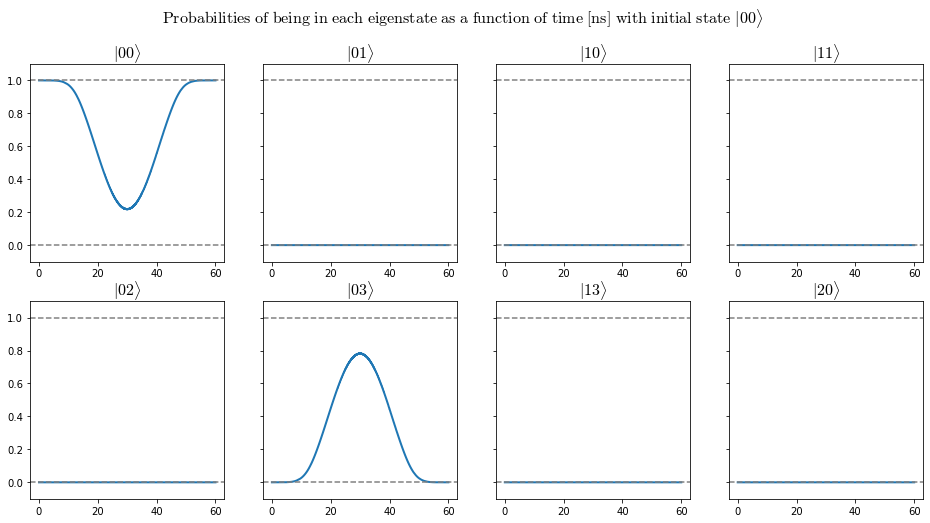

In [12]:
plot_setup = {'lw': 2.0, 'fs': 16, 'fs_text': 14, 'ls': 14}
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray,
    statein_label: str,
    opt: dict
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = (16, 8))
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist, probs[k, :], linewidth=opt['lw'])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k], fontsize=opt['fs'])
        ax[k//4, k%4].set_ylim(-0.1, 1.1)
        ax[k//4, k%4].axhline(y=0, color='grey', linestyle='--')
        ax[k//4, k%4].axhline(y=1, color='grey', linestyle='--')

        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probabilities \ of \ being \ in \ each \ eigenstate \
                 \ as \ a \ function \ of \ time \ [ns] \ with \ initial \ state}$' + 
                 ' $\\vert ' + statein_label + ' \\rangle$', fontsize=opt['fs']) 
    plt.show()

plot_probas(tlist, probs, statein_label, plot_setup)

In [13]:
env_syst = pysqkit.tomography.TomoEnvOld(system = coupled_sys, jump_op=jumps)

Computation time =  52.21216130256653 seconds


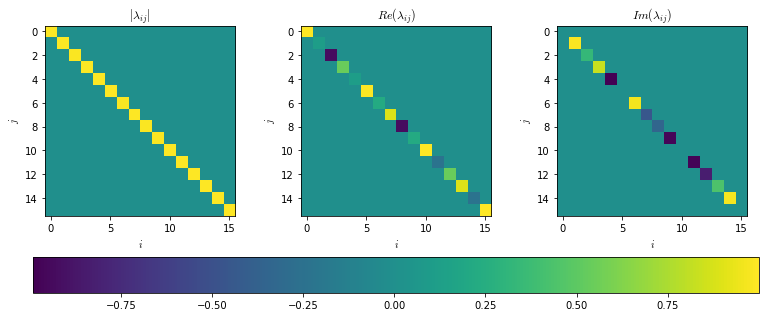

In [14]:
start =  time.time()

lambda_mat = env_syst.fct_to_lambda(in_labels = "comp_states", out_labels = "comp_states", draw_lambda = True, as_qobj = False)

end = time.time()
print("Computation time = " , end - start, "seconds")

In [15]:
def single_qubit_correction(
    u_gate: np.ndarray
) -> np.ndarray:
    phi_10 = cmath.phase(u_gate[2, 2])
    phi_01 = cmath.phase(u_gate[1, 1])
    p_phi10 = np.array([[1, 0], [0, np.exp(-1j*phi_10)]])
    p_phi01 = np.array([[1, 0], [0, np.exp(-1j*phi_01)]])
    return tensor_prod([p_phi10, p_phi01])

def correc_U_fast(env, in_out_labels = "comp_states"):
    if in_out_labels == "comp_states":
        in_out_labels = [(0,0), (0,1), (1,0), (1,1)]

    m_00 = env._label_to_index((0,0))
    
    n_10 = env._label_to_index((1,0))
    n_01 = env._label_to_index((0,1))
    
    ind_10_00 = n_10 * env.d + m_00
    ind_01_00 = n_01 * env.d + m_00
    
    phi_10 = cmath.phase(env.lambda_as_function(ind_10_00, ind_10_00)) # = u_00_00.dag() * u_10_10 because G( |10><00|) = u_00_00.dag() * u_10_10 * |10><00|
    phi_01 = cmath.phase(env.lambda_as_function(ind_01_00, ind_01_00))

    p_phi10 = np.diag(np.ones(env.nb_levels[0])) + 0j
    p_phi01 = np.diag(np.ones(env.nb_levels[1])) + 0j

    p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_10)]]) #proved to work
    p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_01)]])
    
#     print(phi_10, phi_01)
    return tensor_prod([p_phi10, p_phi01])



In [16]:
nb_levels = [levels_t, levels_f]
d = np.prod(nb_levels)

U_ideal = np.diag(np.ones(d))
U_ideal[nb_levels[1]+1, nb_levels[1]+1] = -1

In [17]:
u_gate = np.zeros([4, 4], dtype=complex)
for i in range(0, 4):
    for k in range(0, 4):
        u_gate[i, k] = (state_in[i].dag()*outputs[k].states[nb_points - 1])[0, 0]
        
u_gate = np.conj(u_gate[0, 0])*u_gate 
u_correction = single_qubit_correction(u_gate)
cz = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
u_ideal = u_correction.conj().T.dot(cz)
u_ideal_super = qtp.to_super(qtp.Qobj(u_ideal))[:, :]
u_gate_super = qtp.to_super(qtp.Qobj(u_gate))[:, :]

$U_{\mathrm{ideal}}$ is the ideal gate that we should implement up to the single-qubit corrections. Issue: check lambda mat and the superoperator associated with u_gate.

In [18]:
# This is not working so far
#pysqkit.tomography.tomoEnv.process_fidelity(env_syst, cz, single_qubit_correction_from_lambda)

In [19]:
def process_fidelity(
    supop: np.ndarray,
    ideal_supop: np.ndarray
) -> complex:
    dim_sq = ideal_supop.shape[0] 
    return np.trace(ideal_supop.conj().T.dot(supop))/dim_sq

def average_gate_fidelity() -> float:
    return (d_comp*fpro + 1 - l1)/(d_comp + 1)
    
    

We obtain a process fidelity

In [20]:
fpro = process_fidelity(lambda_mat.conj().T, u_ideal_super)
display(Latex(r'$F_{{pro}} = $ {:.5f}'.format(np.real(fpro))))

<IPython.core.display.Latex object>

and leakage

In [21]:
l1 = env_syst.L1()
display(Latex(r'$L_1 = $ {:.5f}'.format(np.real(l1))))

AttributeError: 'TomoEnvOld' object has no attribute 'definition_type'

This gives average gate fidelity

In [ ]:
fgate = average_gate_fidelity()
display(Latex(r'$F_{{gate}} = $ {:.5f}'.format(np.real(fgate))))

# Checking leakage

In [ ]:
d_comp = 4
d_leak = levels_t*levels_f - d_comp

rho_compspace = 1/d_comp*rhos_by_label[0][0] + 1/d_comp*rhos_by_label[1][0] + \
                 1/d_comp*rhos_by_label[0][1] + 1/d_comp*rhos_by_label[1][1]
ide_tot = qtp.tensor(qtp.Qobj(np.identity(levels_t)), qtp.Qobj(np.identity(levels_f)))
rho_leakspace = 1/d_leak*(ide_tot - d_comp*rho_compspace)
output_compspace = solvkit.integrate(tlist*2*np.pi, rho_compspace, \
                                     hamil0, drive_hamils, pulses, [], "mesolve")
output_leakspace = solvkit.integrate(tlist*2*np.pi, rho_leakspace, \
                                     hamil0, drive_hamils, pulses, [], "mesolve")       


In [ ]:
l1_check = qtp.expect(output_compspace.states[-1], d_leak*rho_leakspace)
display(Latex(r'$L_1^{{check}} = $ {:.5f}'.format(np.real(l1_check))))


In [ ]:
# This function allows to vectorize a density matrix using the same basis as the lambda
# superoperator. It can be used to check that applying the superoperator gives the same
# result as evolving the state using integrate. 
# It seems to work from my initial checks, although the numerical accuracy
# could be better.

def vectorize_density_matrix(
    rho: np.ndarray
) :
    if rho.shape[0] != rho.shape[1]:
        raise ValueError('The density matrix must be a square matrix')
    d = rho.shape[0]
    rho_vec = np.zeros(d**2, dtype=complex)
    for i in range(0, d):
        for k in range(0, d):
            index = i*d + k
            rho_vec[index] = rho[i, k]
    return rho_vec   

In [ ]:
def simulation(scan_params, coupled_sys, jump_op):
    
    
    
    
    swap_angle, phase = scan_params
    gate = fsim_gate(swap_angle=swap_angle, phase=phase, as_xarray=True)
    gate_ptm = kraus_to_ptm(np.array([gate.data]), basis_2q, basis_2q)
    
    # In the actual simulaiton the code that would go here would look more like:
    # amp, freq = scan_params
    # system['fluxonium'].drives[0].set_params(amp=amp, freq=freq)
    # gate_op = sq.tomography(system, in_states, out_states) 
    
    # Where in_states is an array of the |00>, |01>, |10>, |11> obtained from system
    # out_states will be probably the full system state array
    
    # Then one does the analyis on the gate_op
    
    result = {}
    result['process_infid'] = 1 - avg_process_fid(gate_ptm, ideal_cz_ptm)
    result['cond_phase'] = cond_phase(gate)
    return result

In [ ]:
type(coupled_sys)